# Synthetic Case Study:
---
This file contains the implementation of the first experiment presented in the report *(synthetic case)*. The code is easy to follow and since this is a synthetic experiment the data is produces rather than being imported. As mentioned in the section $2.2.1$ of the report, the data is produced via following the function below:
	\begin{eqnarray}
			f_t(x)=
            \begin{cases}
				1010x & \textrm{with probability } 0.01\\
            	-10x & \textrm{otherwise}.
			\end{cases}
		\end{eqnarray}

Where the domain of the function is on $[-1,1]$.

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
class AdamOptimizer(tf.train.Optimizer):
  def __init__(self, learning_rate=0.001, decay=False, beta1=0.9, beta2=0.99,
               epsilon=0.0, var_list=[]):
    self.learning_rate = learning_rate
    self.decay = decay
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    
    self.var_list = var_list
    self.m = {}
    self.v = {}
    self.beta1_t = tf.Variable(1.0, trainable=False)
    self.beta2_t = tf.Variable(1.0, trainable=False)
    self.t = tf.Variable(0.0, trainable=False)
    
    for var in self.var_list:
      self.m[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
      self.v[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
    
  def apply_gradients(self, gradient_variables):
    beta1_t = self.beta1_t.assign(self.beta1_t * self.beta1)
    beta2_t = self.beta2_t.assign(self.beta2_t * self.beta2)
    
    with tf.control_dependencies([self.t.assign_add(1.0), beta1_t, beta2_t]):
      learning_rate = self.learning_rate
      if self.decay:
        learning_rate /= tf.sqrt(self.t)
      update_ops = []

      for (g, var) in gradient_variables:
        m = self.m[var].assign(self.beta1 * self.m[var] + (1 - self.beta1) * g)
        v = self.v[var].assign(self.beta2 * self.v[var] + (1 - self.beta2) * g * g)
        m_hat = m / (1 - beta1_t)
        v_hat = v / (1 - beta2_t)

        update = -learning_rate * m_hat / (self.epsilon + tf.sqrt(v_hat))
        update_ops.append(var.assign_add(update))

      return tf.group(*update_ops)

In [0]:
class AMSGradOptimizer(tf.train.Optimizer):
  def __init__(self, learning_rate=0.001, decay=False, beta1=0.9, beta2=0.99,
               epsilon=0.0, var_list=[]):
    self.learning_rate = learning_rate
    self.decay = decay
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    
    self.var_list = var_list
    self.m = {}
    self.v = {}
    self.v_hat = {}
    self.t = tf.Variable(0.0, trainable=False)
    
    for var in self.var_list:
      self.m[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
      self.v[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
      self.v_hat[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
    
  def apply_gradients(self, gradient_variables):
    with tf.control_dependencies([self.t.assign_add(1.0)]):
      learning_rate = self.learning_rate
      if self.decay:
        learning_rate /= tf.sqrt(self.t)
      update_ops = []

      for (g, var) in gradient_variables:
        m = self.m[var].assign(self.beta1 * self.m[var] + (1 - self.beta1) * g)
        v = self.v[var].assign(self.beta2 * self.v[var] + (1 - self.beta2) * g * g)
        v_hat = self.v_hat[var].assign(tf.maximum(self.v_hat[var], v))

        update = -learning_rate * m / (self.epsilon + tf.sqrt(v_hat))
        update_ops.append(var.assign_add(update))

      return tf.group(*update_ops)

In [0]:
def test_optimizer(optimizer_name, iterations=1000000, learning_rate=0.001,
                   decay=False):
  tf.reset_default_graph()
  
  with tf.Session() as sess:
    r = tf.distributions.Bernoulli(probs=0.01, dtype=tf.float32).sample()
    x = tf.Variable(0.0)
    loss = (r * 1010 - (1 - r) * 10) * x
    var_list = [x]
    gradient = tf.gradients(loss, var_list)

    if optimizer_name == "adam":
      optimizer = AdamOptimizer(var_list=var_list, learning_rate=learning_rate,
                                decay=decay)
    elif optimizer_name == "amsgrad":
      optimizer = AMSGradOptimizer(var_list=var_list, learning_rate=learning_rate,
                                   decay=decay)
    else:
      raise Exception("Unknown optimizer")

    update_op = optimizer.apply_gradients([(grad, var) for grad, var in zip(gradient, var_list)])
    with tf.control_dependencies([update_op]):
      clip_op = x.assign(tf.clip_by_value(x, -1.0, 1.0))

    sess.run(tf.global_variables_initializer())

    results = []

    for i in range(iterations):
      _, cur_x = sess.run([clip_op, x])
      results.append(cur_x)
      
      if i % 500000 == 0:
        print(cur_x)

    return results

In [0]:
results_adam = test_optimizer("adam", iterations=5000000, learning_rate=0.5,
                              decay=True)

0.49999967
0.99512786
0.9844877
1.0
0.9932289
0.99537265
0.99267393
0.99408305
0.9928383
0.99858236


In [0]:
results_amsgrad = test_optimizer("amsgrad", iterations=10000000, learning_rate=0.5,
                                 decay=True)

0.50000006
-0.84852177
-0.9791989
-0.99953294
-0.87611675
-0.98729575
-0.9243118
-0.9561422
-0.9893523
-0.9869937
-0.9866559
-0.97423553
-0.9717627
-0.9841555
-0.9432347
-0.9875955
-0.9563815
-0.99707234
-0.9990677
-0.987113


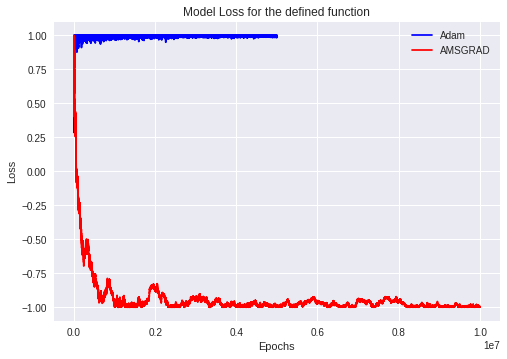

In [0]:
plt.plot(results_adam, label="Adam", color=(0,0,1))
plt.plot(results_amsgrad, label="AMSGRAD",color=(1,0,0))
plt.legend(bbox_to_anchor=(0.8, 0.9), loc=2, borderaxespad=0.)


plt.title('Model Loss for the defined function')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()